In [1]:
import random
import galois
from py_ecc.bls12_381 import curve_order
from pympler import asizeof
import os
from math import floor, ceil
import matplotlib.pyplot as plt


from kzg import TrustedEntity, KZGProver, KZGVerifier
from verkle_tree import LeafNode, VerkleTreeNode, VerkleTreeVerifier

Generate Galois field - this may take a few minutes.

In [2]:
GF = galois.GF(curve_order)

# KZG polynomial commitment scheme

KZG allows us to commit to an array of values and prove that a subset of values is part of the commited array.

In [3]:
SRS_degree = 20
kzg_trusted_entity = TrustedEntity(GF, curve_order, SRS_degree)
kzg_prover = KZGProver(GF, curve_order, SRS_degree, kzg_trusted_entity.SRS_1, kzg_trusted_entity.SRS_2)
kzg_verifier = KZGVerifier(GF, curve_order, SRS_degree, kzg_prover.SRS_1, kzg_prover.SRS_2)

arr = [(0, 10), (1, 20), (2, 36), (3, 50), (4, 90), (5, 44), (6, 66)]
print("Array: ", arr)
polynomial = kzg_prover.arr_to_poly(arr)
print("Polynomial: ", polynomial)
commitment = kzg_prover.commit_poly(polynomial)
print("Commitment: ", commitment)

# Batch proof
print("\nBATCH PROOF")
points = [(0, 10), (1, 20), (5, 44)]
proof = kzg_prover.generate_batch_proof(polynomial, points)
print("Batch proof: ", proof)
kzg_verifier.verify_batch_proof(commitment, points, proof)
print("Batch proof is valid")

# One point proof
print("\nONE POINT PROOF")
point = (3, 50)
one_point_proof = kzg_prover.generate_one_point_proof(polynomial, point)
print("One point proof: ", one_point_proof)
kzg_verifier.verify_one_point_proof(commitment, point, one_point_proof, kzg_verifier.SRS_2)
print("One point proof is valid")

Array:  [(0, 10), (1, 20), (2, 36), (3, 50), (4, 90), (5, 44), (6, 66)]
Polynomial:  31024559478616329367006579800676696453966910229478852378373831397463660534171x^6 + 20537384443591091271117031699039503286428799729373324813853099657475944297254x^5 + 6554484396890773809930967563523245729711319062565954727825457337492322648149x^4 + 28402765719860019843034192775267398162082382604452470487243648462466731474701x^3 + 14856831299619087302510193143986023654012323208482830716404369964982598002597x^2 + 3495725011675079365296516033879064389179370166701842521506910579995905412164x + 10
Commitment:  (266164936910997979340782083543021878046644023724616487751782981482013186759814887882431042449011999282849234501381, 3406234663089605980686324772122430101486430582081803112701362180782563286293037583911737965405505655836201338700735)

BATCH PROOF
Batch proof:  (65118281582240915871261593425174290230288004296653262382905281075014786796294037408843795501827114737804213952418, 9245615511424839829174579473

# Verkle tree

Verkle tree allows us to prove that a certain subset of leaves is indeed part of the tree.

In [4]:
l1 = [10, 20, 31, 40, 51, 60, 70, 80, 90, 100]
l2 = [30, 40, 50, 60, 70, 81, 90, 100, 110, 120]
l3 = [31, 41, 51, 61, 71, 85, 91, 101, 111, 122]
l4 = [35, 42, 56, 4431, 12171, 2385, 9145, 1012, 28111, 232322]
n1 = VerkleTreeNode(curve_order, list(map(LeafNode, l1)), kzg_prover)
n2 = VerkleTreeNode(curve_order, list(map(LeafNode, l2)), kzg_prover)
n3 = VerkleTreeNode(curve_order, list(map(LeafNode, l3)), kzg_prover)
n4 = VerkleTreeNode(curve_order, list(map(LeafNode, l4)), kzg_prover)
root = VerkleTreeNode(curve_order, [n1, n2, n3, n4], kzg_prover)

print("VERKLE TREE")
print("Number of elements: ", len(root))
print("Root Commitment: ", root.commitment)
path = {0: [(1, 20), (2, 31), (3, 40)], 1: [(1, 40), (2, 50), (3, 60)]}
print("Path", path)
proof = root.generate_proof(path)
print("Proof", proof)

verifier = VerkleTreeVerifier(root.commitment, kzg_verifier)
verifier.validate_proof(path, proof)
print("Proof is valid")

VERKLE TREE
Number of elements:  40
Root Commitment:  (3213104128626950230931064506538007488771750482724631194755714678421647446815348064280023550520901828662639662899406, 1434755804221796294097852973306211537422088441377880152114792348532225127854810208818041079288006781786911721220689)
Path {0: [(1, 20), (2, 31), (3, 40)], 1: [(1, 40), (2, 50), (3, 60)]}
Proof {-1: Proof(commitment=(3213104128626950230931064506538007488771750482724631194755714678421647446815348064280023550520901828662639662899406, 1434755804221796294097852973306211537422088441377880152114792348532225127854810208818041079288006781786911721220689), proof=(1593963774160313169863225848834130385373989768504590553019428769345451517685668766251655864593816815324523038127203, 910975064335075877993949050795882962543518062392308767226366360212389607485327966183177827508322008064373297484048)), 0: Proof(commitment=(317475169493712619477698293251408013921079355506129022319903522498588005661715934751586259724904072670183750422446

In [5]:
def build_tree(depth, width, kzg_prover):
    if depth == 1:
        return LeafNode(random.randint(1, curve_order))
    
    t1 = build_tree(depth - 1, width, kzg_prover)
    t2 = build_tree(depth - 1, width, kzg_prover)
    l = [t1 for _ in range(floor(width / 2))] + [t2 for _ in range(ceil(width / 2))]
    # Values in the list should be different - polynomial should not be constant -
    # we shuffle values at each level instead of allocating random values
    # for memory efficiency
    random.shuffle(l)
    a = VerkleTreeNode(curve_order, l, kzg_prover)
    return a

def build_path(tree):
    if type(tree) == LeafNode:
        return [(0, tree.get_value())]

    if type(tree.children[0]) == LeafNode:
        return [(0, tree.children[0].get_value()), (1, tree.children[1].get_value())]
    
    return {0: build_path(tree.children[0])}

In [6]:
SRS_degree = 30
kzg_trusted_entity = TrustedEntity(GF, curve_order, SRS_degree)
kzg_prover = KZGProver(GF, curve_order, SRS_degree, kzg_trusted_entity.SRS_1, kzg_trusted_entity.SRS_2)

# TODO: pump to 6
depth = 4
width = 30
root = build_tree(depth, width, kzg_prover)
path = build_path(root)
print("Path", path)
proof = root.generate_proof(path)
print("Proof", proof)
print("Proof size in bytes: ", asizeof.asizeof(proof))
print("Number of elemtns:", len(root))

Path {0: {0: [(0, 10359562112904674645633809192946355012322524449158925438204738996302891691221), (1, 8425196809534473228502834509282828139667629921889866930000242217907504808917)]}}
Proof {-1: Proof(commitment=(1462753868998499419725351751053153050181301698918623051030526597002145505541098030262658138734442016134214521265957, 207352547521840696999003120646518686303818780304393620693755420120514718277944798708794620929344153596224351620239), proof=(1164068695371952579755043662105144549976203771475491395949276059685650433357780870659710804530377262228353560040743, 3588022581031869042713755352366901403876777198419864676093704479263767854163965590510216504349982326955537854154916)), 0: {-1: Proof(commitment=(3308162867533761752158430766783448622021559682426309543755708601878965188208713547369690460241614736579042037558166, 3541075217901142888642003946633644490824673204105546258412809570133137940776805338295018361225388540971325710535349), proof=(2495301691310738924387200027890048605764560

Depth: 2, width: 5, number of elements: 5, proof size: 1088 bytes
Depth: 3, width: 5, number of elements: 25, proof size: 2408 bytes
Depth: 4, width: 5, number of elements: 125, proof size: 3664 bytes
Depth: 5, width: 5, number of elements: 625, proof size: 4920 bytes
Depth: 6, width: 5, number of elements: 3125, proof size: 6176 bytes
Depth: 2, width: 10, number of elements: 10, proof size: 1088 bytes
Depth: 3, width: 10, number of elements: 100, proof size: 2408 bytes
Depth: 4, width: 10, number of elements: 1000, proof size: 3664 bytes
Depth: 5, width: 10, number of elements: 10000, proof size: 4920 bytes
Depth: 6, width: 10, number of elements: 100000, proof size: 6176 bytes
Depth: 2, width: 20, number of elements: 20, proof size: 1088 bytes
Depth: 3, width: 20, number of elements: 400, proof size: 2408 bytes
Depth: 4, width: 20, number of elements: 8000, proof size: 3664 bytes
Depth: 5, width: 20, number of elements: 160000, proof size: 4920 bytes
Depth: 6, width: 20, number of el

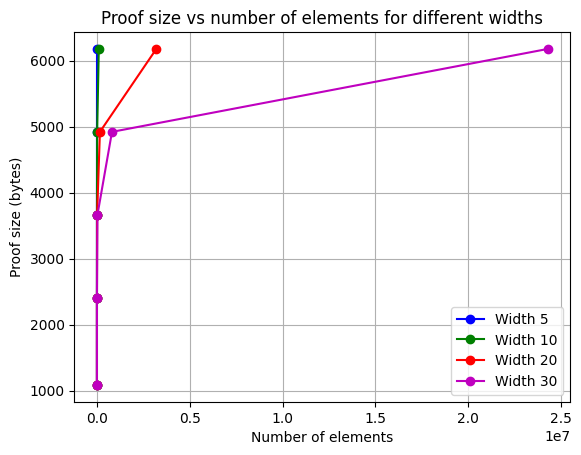

In [7]:
depths = range(2, 7)
widths = [5, 10, 20, 30]
colors = ["b", "g", "r", "m", "y", "k"]

for i, width in enumerate(widths):
    proof_sizes = []
    num_elements = []
    for d in depths:
        SRS_degree = width
        kzg_trusted_entity = TrustedEntity(GF, curve_order, SRS_degree)
        kzg_prover = KZGProver(GF, curve_order, SRS_degree, kzg_trusted_entity.SRS_1, kzg_trusted_entity.SRS_2)

        root = build_tree(d, width, kzg_prover)
        path = build_path(root)
        proof = root.generate_proof(path)
        proof_size = asizeof.asizeof(proof)
        proof_sizes.append(proof_size)
        num_elements.append(len(root))
        print(f"Depth: {d}, width: {width}, number of elements: {len(root)}, proof size: {proof_size} bytes")
    
    plt.plot(num_elements, proof_sizes, marker='o', color=colors[i % len(colors)], label=f'Width {width}')

plt.xlabel('Number of elements')
plt.ylabel('Proof size (bytes)')
plt.title('Proof size vs number of elements for different widths')
plt.legend()
plt.grid(True)

output_path = os.path.join("figures", "proof_size_plot.pdf")
plt.savefig(output_path, format="pdf")

plt.show()